In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging
import pickle
from sklearn.preprocessing import MultiLabelBinarizer
import plotly.express as px
import plotly.graph_objects as go
from sklearn.manifold import TSNE
import numpy as np; np.random.seed(0)
from scipy.cluster import hierarchy
import seaborn as sns; sns.set_theme()
import plotly.figure_factory as ff
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import train_test_split

from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import silhouette_score


In [2]:
path="E:\ITIAI2021\ML1\datascience\stack-overflow-developer-survey-2021\prep2.pkl"

data=pd.read_pickle(path)

In [4]:
#data

In [88]:
ROLE_COLS = ['DevType']
TECH_COLS = ['LanguageHaveWorkedWith','DatabaseHaveWorkedWith','WebframeHaveWorkedWith','MiscTechHaveWorkedWith']

In [89]:
#fill nan with empty list 
for col in ROLE_COLS+TECH_COLS:
    
    null =data[col].isnull()
    data[col].loc[null] = data[col].loc[null].apply(lambda x: [])

# hot encoding

In [90]:
dfcol={}
for col in ROLE_COLS+TECH_COLS:
    binarizer = MultiLabelBinarizer()
    encoded_df = pd.DataFrame(binarizer.fit_transform(data[col]),columns=binarizer.classes_,
                               index=data[col].index)
    dfcol[col]=encoded_df


In [91]:
data=pd.concat(dfcol,axis=1)
data

DevType                           \
      Academic researcher Data or business analyst   
0                       0                        0   
1                       0                        0   
2                       0                        0   
3                       0                        0   
4                       0                        0   
...                   ...                      ...   
83434                   0                        0   
83435                   0                        0   
83436                   0                        0   
83437                   0                        0   
83438                   0                        0   

                                                                            \
      Data scientist or machine learning specialist Database administrator   
0                                                 0                      0   
1                                                 0                      0   
2                                                 0                      0   
3                                                 0                      0   
4                                                 0                      0   
...                                             ...                    ...   
83434                                             0                      0   
83435                                             0                      0   
83436                                             1                      0   
83437                                             0                      0   
83438                                             0                      0   

                                                                            \
      Designer DevOps specialist Developer, QA or test Developer, back-end   
0            0                 0                     0                   0   
1            0                 0                     0                   0   
2            0                 0                     0                   0   
3            0                 0                     0                   0   
4            0                 0                     0                   0   
...        ...               ...                   ...                 ...   
83434        0                 0                     0                   1   
83435        0                 0                     0                   0   
83436        0                 1                     0                   0   
83437        0                 0                     0                   1   
83438        0                 0                     0                   1   

                                                     \
      Developer, desktop or enterprise applications   
0                                                 0   
1                                                 0   
2                                                 0   
3                                                 0   
4                                                 1   
...                                             ...   
83434                                             0   
83435                                             0   
83436                                             0   
83437                                             0   
83438                                             0   

                                                   ... MiscTechHaveWorkedWith  \
      Developer, embedded applications or devices  ...                Cordova   
0                                               0  ...                      0   
1                                               0  ...                      1   
2                                               0  ...                      0   
3                                               0  ...                      0   
4                                               0  ...                      0   
..

# Dimentionality reduction
-T-SNE : non linear dim red.
t-distribution stochastic neighbour embedding

In [92]:
#drop target
# Prepare sub data frames 
skills = data.drop('DevType', axis=1).copy()
std_skills = StandardScaler().fit_transform(skills)

c:\users\المهندس\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.

c:\users\المهندس\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.



In [93]:
tsne_projection = TSNE(n_components=2, 
                       perplexity=3,
                       learning_rate=0.01,
                       init='pca', 
                       method='barnes_hut', 
                       n_jobs=2, 
                       n_iter=10**10,
                       random_state=0).fit_transform(std_skills.T)

tsne_projection = pd.DataFrame(tsne_projection, index=skills.columns)

c:\users\المهندس\appdata\local\programs\python\python39\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



In [94]:
tsne_projection

0           1
LanguageHaveWorkedWith APL             -7.438958   41.440331
                       Assembly       -69.320877   59.439903
                       Bash/Shell     -86.071556   45.645069
                       C              -72.137772   64.298210
                       C#             125.660049  106.496201
...                                          ...         ...
MiscTechHaveWorkedWith Pandas        -104.978561   56.710320
                       Qt             -72.449364   74.353294
                       React Native    56.346386 -100.110535
                       TensorFlow    -122.380615   55.912758
                       Torch/PyTorch -124.990509   60.799183

[83 rows x 2 columns]

In [95]:
tsne_projection.shape

(83, 2)

In [97]:
#plot
fig = px.scatter(x=tsne_projection[0], y=tsne_projection[1],text=tsne_projection.droplevel(0).index)
fig.update_traces(textposition='top center')
fig.update_layout(height=600, width=600, title_text='TSNE')
fig.show()

# cluster data after we show the relation

In [105]:
range_n_cluster = list(range(10,25)) #to define optimal cluster
silhoutte_score = []
best_cluster_model = None 

for n_clusters in range_n_cluster:
    cluster_model  = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    cluster_labels = cluster_model.fit_predict(tsne_projection)
    
    silhouette_avg = silhouette_score(tsne_projection, cluster_labels)
    silhoutte_score += [silhouette_avg]
    
    if silhouette_avg >= np.max(silhoutte_score): #compare
        best_cluster_model = cluster_model

In [106]:
best_cluster_model

AgglomerativeClustering(n_clusters=18)

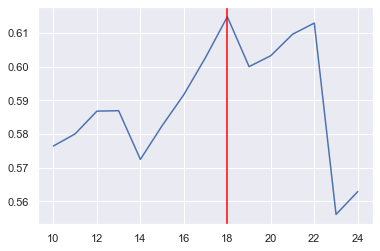

In [111]:
# plot NUM of cluser and silhouette
plt.plot(range_n_cluster, silhoutte_score)
plt.axvline(best_cluster_model.n_clusters,color='red')

In [112]:
#we have 18 group so we name it 
skill_group=["Skill_group"+str(label) for label in best_cluster_model.labels_]

In [115]:
fig = px.scatter(x=tsne_projection[0], 
                 y=tsne_projection[1], 
                 text=tsne_projection.droplevel(0).index, 
                 color=cluster_labels)
fig.update_traces(textposition='top center')
fig.update_layout(height=800, width=800, title_text='Cluster')
fig.show()

In [144]:
# dic=tsne_projection.droplevel(0).index.groupby(cluster_labels)
# for key,v in dic.items():
#     print(v.tolist())

In [150]:
# How to better write this
skills_clusters = tsne_projection.index.droplevel(0).to_series().groupby([skill_group]).apply(list)

In [151]:
skills_clusters

Skill_group0     [PHP, SQL, MariaDB, MySQL, SQLite, Drupal, Lar...
Skill_group1                    [Clojure, Go, Haskell, LISP, Rust]
Skill_group10                    [Julia, Matlab, R, NumPy, Pandas]
Skill_group11    [TypeScript, Angular, Angular.js, Svelte, Cord...
Skill_group12    [Cassandra, Couchbase, DynamoDB, Elasticsearch...
Skill_group13                       [HTML/CSS, JavaScript, jQuery]
Skill_group14                                 [Objective-C, Swift]
Skill_group15                                     [Elixir, Erlang]
Skill_group16                                [Ruby, Ruby on Rails]
Skill_group17                        [Scala, Apache Spark, Hadoop]
Skill_group2     [Bash/Shell, Perl, Python, Django, FastAPI, Fl...
Skill_group3                [APL, COBOL, Crystal, Delphi, IBM DB2]
Skill_group4     [Node.js, MongoDB, Express, Gatsby, React.js, ...
Skill_group5     [C#, F#, PowerShell, VBA, Microsoft SQL Server...
Skill_group6                [Groovy, Java, Kotlin, Oracle, Spr

In [5]:
from sklearn.cluster import DBSCAN


from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from sklearn.metrics import silhouette_score

In [7]:
clustering = DBSCAN(eps=.2, min_samples=6).fit(data)
# grab only clustered data points
label=clustering.labels_
score=silhouette_score(data,label)
score

ValueError: could not convert string to float: 'I am a developer by profession'